<h1>Машинне навчання</h1>
<p>Ю.С. Процик. Курс лекцій</p>
<div align="right"><em>Cформовано на основі <a href="https://mlcourse.ai">відкритого курсу</a> Юрія Кашницького</em></div>

# <center>Тема 4. Лінійні моделі класифікації та регресії
    
## <center>Частина 3. Де логістична регресія працює добре і де не дуже
    
## План

1. [Аналіз відгуків IMDB до фільмів](#1.-Аналіз-відгуків-IMDB-до-фільмів)
2. [Простий підрахунок слів](#2.-Простий-підрахунок-слів)
3. [XOR-проблема](#3.-XOR-проблема)

## 1. Аналіз відгуків IMDB до фільмів

Будемо розв'язувати задачу бінарної класифікації відгуків IMDB до фільмів. Є навчальна вибірка з розміченими відгуками, про 12500 відгуків відомо, що вони хороші, ще про 12500 – що вони погані. Тут вже не так просто відразу приступити до машинного навчання, тому що готової матриці $X$ немає –  її треба приготувати. Будемо використовувати найпростіший підхід –  мішок слів ("Bag of words"). При такому підході ознаками відгуку будуть індикатори наявності в ньому кожного слова з усього корпусу, де корпус – це множина всіх відгуків. Ідея ілюструється рисунком

<img src="../img/bag_of_words.svg" width=80%>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

**Для початку автоматично завантажуємо набір даних [звідси](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) і розархівовуємо його разом з рештою даних у папку data. Короткий опис набору даних [тут](http://ai.stanford.edu/~amaas/data/sentiment/). У навчальній і тестовій вибірках по 12500 тисяч хороших і поганих відгуків до фільмів.**

In [2]:
from io import BytesIO
import requests
import tarfile

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def load_imdb_dataset(extract_path="../data", overwrite=False):
    # перевіряємо чи вже існує
    if os.path.isfile(os.path.join(extract_path, "aclImdb", "README")) and not overwrite:
        print("Набір даних IMDB вже існує.")
        return
    
    print("Завантаження набору даних з:  ", url)
    response = requests.get(url)
    
    tar = tarfile.open(mode= "r:gz", fileobj = BytesIO(response.content))
    
    data = tar.extractall(extract_path)
    
load_imdb_dataset()

Набір даних IMDB вже існує.


In [3]:
# поміняйте шлях, якщо потрібно
PATH_TO_IMDB = "../data/aclImdb"

reviews_train = load_files(os.path.join(PATH_TO_IMDB, "train"),
                           categories=['pos', 'neg'])
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"),
                          categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [4]:
print("Кількість записів в навчальних даних: %d" % len(text_train))
print(np.bincount(y_train))
print("Кількість записів в тестових даних: %d" % len(text_test))
print(np.bincount(y_test))

Кількість записів в навчальних даних: 25000
[12500 12500]
Кількість записів в тестових даних: 25000
[12500 12500]


**Приклад відгуку та відповідної мітки.**

In [5]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [6]:
y_train[1] # поганий відгук

0

In [7]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [8]:
y_train[2] # хороший відгук

1

## 2. Простий підрахунок слів

**Складемо словник усіх слів за допомогою CountVectorizer.**

In [9]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**Подивимося на приклади отриманих "слів" (краще їх називати токенами). Бачимо, що багато важливих етапів обробки тексту ми тут пропустили (автоматична обробка текстів – це могло би бути темою окремої серії лекцій).**

In [10]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


**Закодуємо речення з текстів навчальної вибірки індексами слів, що входять в них. Використовуємо розріджений формат.**

In [11]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

**Подивимося як працює перетворення.**

In [12]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [13]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562])

In [14]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562]))

**Перетворимо так само тестову вибірку.**

In [15]:
X_test = cv.transform(text_test)

**Навчимо логістичну регресію.**

In [16]:
%%time
logit = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

Wall time: 9.82 s


LogisticRegression(n_jobs=-1, random_state=7)

**Подивимося на частки правильних відповідей на навчальній і тестовій вибірках.**

In [17]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3)

(0.981, 0.864)

**Коефіцієнти моделі можна красиво відобразити.**

In [18]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # беремо коефіцієнти з великими абсолютними значеннями
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # візуалізуємо
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

In [19]:
def plot_grid_scores(grid, param_name):
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_train_score"],
        color="green",
        label="train",
    )
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_test_score"],
        color="red",
        label="test",
    )
    plt.legend();

In [20]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();    

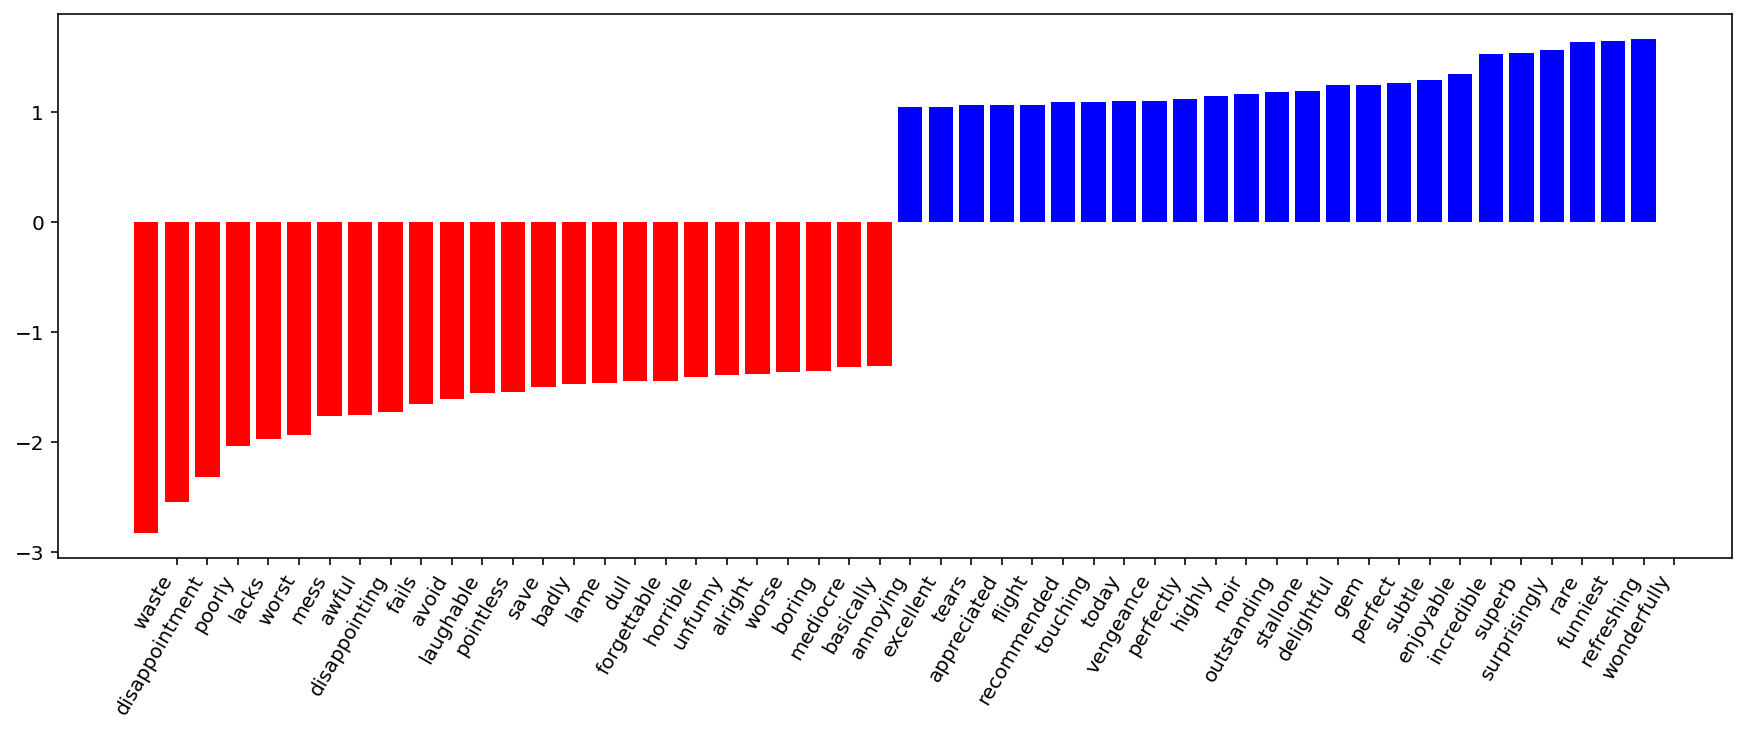

In [21]:
visualize_coefficients(logit, cv.get_feature_names())

**Підберемо коефіцієнт регуляризації для логістичної регресії. Використовуємо `sklearn.pipeline`, оскільки` CountVectorizer` правильно застосовувати тільки на тих даних, на яких в поточний момент навчається модель (щоб не "підглядати" в тестову вибірку і не брати до уваги по ній частоти входження слів). В даному випадку `pipeline` задає послідовність дій: застосувати` CountVectorizer`, потім навчити логістичну регресію.**

In [22]:
%%time
from sklearn.pipeline import make_pipeline
# make_pipeline на відміну від Pipeline автоматично генерує назви кроків

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(solver='lbfgs', 
                                                   n_jobs=-1, 
                                                   random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

0.86396
Wall time: 24.9 s


In [23]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, 
                          param_grid_logit, 
                          return_train_score=True, 
                          cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

Wall time: 2min 35s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True)

**Краще значення C і відповідна якість на крос-валідації:**

In [24]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.8853999276361743)

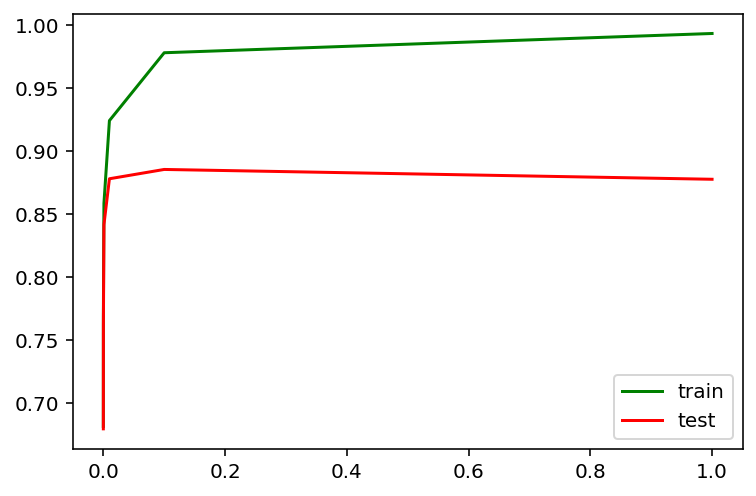

In [25]:
plot_grid_scores(grid_logit, 'logisticregression__C')

На відкладеній вибірці:

In [26]:
grid_logit.score(text_test, y_test)

0.87812

**Тепер те ж саме, але з випадковим лісом. Бачимо, що з логістичною регресією ми досягаємо більшої частки правильних відповідей меншими зусиллями.**

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
forest = RandomForestClassifier(n_estimators=200, 
                                n_jobs=-1, random_state=17)

In [29]:
%%time
forest.fit(X_train, y_train)

Wall time: 1min 32s


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [30]:
round(forest.score(X_test, y_test), 3)

0.855

## 3. XOR-проблема
Тепер розглянемо приклад, де лінійні моделі справляються гірше.

Лінійні методи класифікації будують все ж дуже просту розділяючу поверхню – гіперплощину. Найвідоміший іграшковий приклад, в якому класи не можна без помилок розділити гіперплощиною (тобто прямою, якщо це 2D), отримав назву "the XOR problem".

XOR – це "виключне АБО", булева функція з наступною таблицею істинності:

<img src='../img/XOR_table.gif'>

XOR дав назву простій задачі бінарної класифікації, в якій класи представлені витягнутими по діагоналях хмарами точок, що перетинаються.

In [31]:
# створюємо дані
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

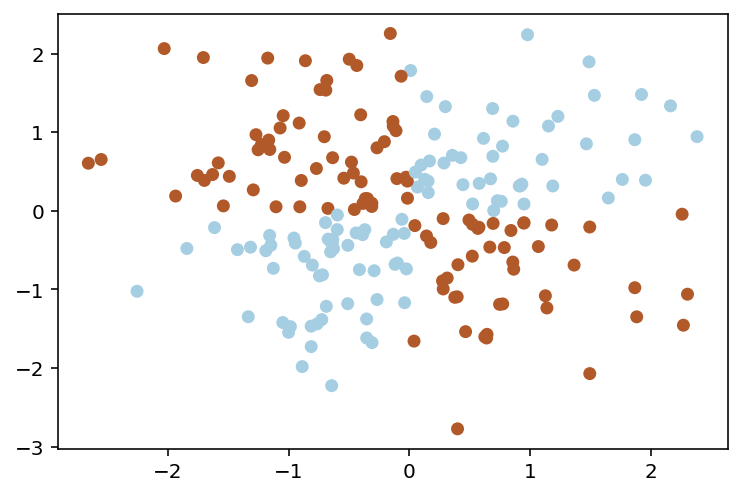

In [32]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Очевидно, не можна провести пряму так, щоб без помилок відокремити один клас від іншого. Тому логістична регресія погано справляється з такою задачею.

In [33]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # візуалізація рішаючої функції для кожної точки даних у сітці
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

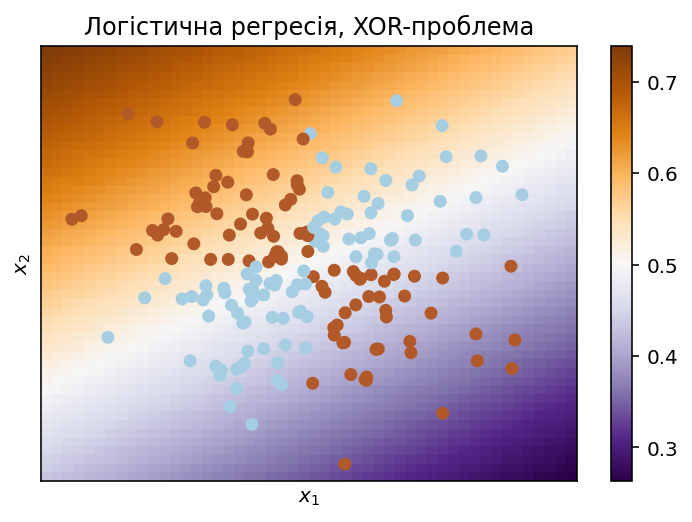

In [34]:
plot_boundary(LogisticRegression(solver='lbfgs'), X, y,
              "Логістична регресія, XOR-проблема")

А ось якщо на вхід подати поліноміальні ознаки, в даному випадку до 2 степеня, то проблема вирішується.

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [36]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression(solver='lbfgs'))])

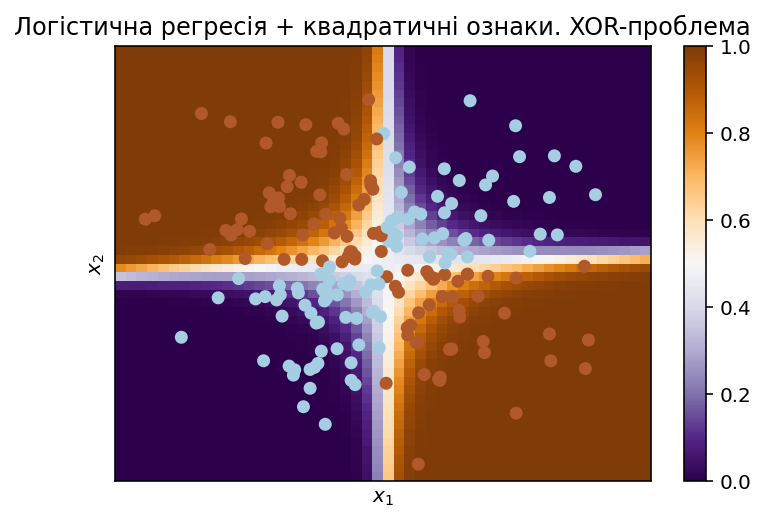

In [37]:
plot_boundary(logit_pipe, X, y,
              "Логістична регресія + квадратичні ознаки. XOR-проблема")

Тут логістична регресія все одно будувала гіперплощину, але в 6-вимірному просторі ознак $1, x_1, x_2, x_1^2, x_1x_2$ і $x_2^2$. У проекції на вихідний простір ознак $x_1, x_2$ межа вийшла нелінійною.

На практиці поліноміальні ознаки дійсно допомагають, але будувати їх явно – обчислювально неефективно. Набагато швидше працює SVM з ядровим трюком. При такому підході в просторі великої розмірності обчислюється тільки відстань між об'єктами (що задається функцією-ядром) і немає необхідності явно створювати комбінаторно велику кількість ознак.